# Evaluate ASR Systems Accent Robutness

The evaluation will be conducted using the subset of AccentsDB , an invaluable resource due to its vast linguistic diversity and accent variations to evaluate the pre-trained models.

The pre-trained models will be utilised without any fine-tuning. This methodology allows us to assess the out-of-the-box performance of these models, specifically their robustness to diverse accents that exist in the AccentsDB. This baseline performance could be a reference point for future endeavours involving model fine-tuning or optimization.

Each model’s performance will be reported separately for each accent category present in AccentsDB. This practice provides insights into each model’s proficiency and potential biases toward certain accents, thereby pointing out avenues for targeted improvements.


## Models
We will compare the performance of the following ASR models:

* **Whisper**: OpenAI’s ASR system trained on vast and diverse datasets.
* **HuBERT**: Facebook AI’s ASR model pre-trained on LibriSpeech. Developed to have a competitive or superior performance to the wav2vec 2.0 on all fine-tuning subsets.
* **Wav2Vec 2.0**: Facebook AI’s ASR model trained using a novel self-supervised learning approach. 3.5.1 Whisper

## Install Dependencies


In [ ]:
!pip install transformers librosa datasets jiwer

## Import Libraries

In [2]:
import os
import time
from multiprocessing import get_context

from tqdm import tqdm
from datasets import load_dataset, Audio
import pandas as pd

from transformers import Wav2Vec2ForCTC, AutoProcessor
from transformers import HubertForCTC
from transformers import WhisperProcessor, WhisperForConditionalGeneration


import torch

## Load Dataset

In [ ]:
dataset = load_dataset("prince-canuma/accentsDB-with-transcripts")

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'transcription'],
        num_rows: 12585
    })
})

In [ ]:
dataset['train'][2]['audio']

{'path': '/Users/prince_canuma/Documents/Projects/MSc thesis/accentsDB/data/american/speaker_01/american_s01_003.wav',
 'array': array([0., 0., 0., ..., 0., 0., 0.]),
 'sampling_rate': 22050}

In [4]:
def map_to_array(batch):
    batch["speech"] = batch["audio"]["array"]
    return batch

def remove_punctuation(input_string):
    # Remove punctuation characters from the input string
    no_punct_string = input_string.replace(".", "")
    return no_punct_string

def map_to_pred(batch, pool, model_name, model, processor):
    if "whisper" in model_name:
        inputs = processor(batch["speech"], sampling_rate=16000, return_tensors="pt")
    else:
        inputs = processor(batch["speech"], sampling_rate=16000, return_tensors="pt", padding=True)

    inputs = {k: inputs[k].to("cuda") for k in inputs}

    with torch.no_grad():
        if "whisper" in model_name:
            predicted_ids = model.generate(**inputs)[0]
        else:
            logits = model(**inputs).logits
    if "whisper" in model_name:
        transcription = processor.decode(predicted_ids.cpu().numpy(), skip_special_tokens=True, pool=pool)
    else:
        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = processor.batch_decode(predicted_ids, pool)

    batch[f"transcription_{model_name}"] = transcription
    return batch

In [5]:
dataset = dataset.map(map_to_array, remove_columns=["audio"])

Map:   0%|          | 0/12585 [00:00<?, ? examples/s]

In [6]:
def get_transcriptions(model_name, model, processor, batched, batch_size):

    with get_context("fork").Pool(processes=2) as pool:

        return dataset.map(
            map_to_pred,
            batched=batched,
            batch_size=batch_size,
            remove_columns=["speech"],
            fn_kwargs={"processor": processor, "model_name": model_name, "model": model, "pool": pool},
        )

def save_predictions(model_name, model, processor, batched=True, batch_size=2):

    result = get_transcriptions(model_name, model, processor, batched, batch_size)
    result["train"].to_pandas().to_csv(f"../results/{model_name}_results.csv",index=False)

## Load models and get predictions

In [ ]:
wav2vec2_processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")
wav2vec2 = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").to("cuda")

save_predictions("wav2vec2", wav2vec2, wav2vec2_processor, batch_size=8)

In [ ]:
hubert_processor = AutoProcessor.from_pretrained("facebook/hubert-large-ls960-ft")
hubert = HubertForCTC.from_pretrained("facebook/hubert-large-ls960-ft").to("cuda")
save_predictions("hubert", hubert, hubert_processor)

In [ ]:
whisper_base_processor = WhisperProcessor.from_pretrained("openai/whisper-base")
whisper_base = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base").to("cuda")

save_predictions("whisper_base", whisper_base, whisper_base_processor, batched=False, batch_size=1)

In [ ]:
whisper_base_en_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
whisper_base_en = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base.en").to("cuda")

save_predictions("whisper_base_en", whisper_base_en, whisper_base_en_processor, batched=False, batch_size=1)

## Evaluation

The primary metric for evaluation will be the Word Error Rate(WER), which measures the percentage of words that were transcribed incorrectly. Additionally, we will use the Character Error(CER) to measure the number of character-level mistakes in the transcriptions. These metrics will provide a clear picture of the transcription accuracy of the evaluated models.

In [29]:
import pandas as pd
from jiwer import cer, wer

In [2]:
wav2vec2_df = pd.read_csv("../results/wav2vec2_results.csv")
hubert_df = pd.read_csv("../results/hubert_results.csv")
whisper_base_df = pd.read_csv("../results/whisper_base_results.csv")
whisper_base_en_df = pd.read_csv("../results/whisper_base_en_results.csv")
clean_df = pd.read_csv("../accentsDB/metadata.csv")

In [3]:
# Make whisper_base and whisper_base_en columns uppercase and remove commas and periods.
whisper_base_df['transcription_whisper_base'] = whisper_base_df['transcription_whisper_base'].str.upper().str.replace(',', '').str.replace('.', '')
whisper_base_en_df['transcription_whisper_base_en'] = whisper_base_en_df['transcription_whisper_base_en'].str.upper().str.replace(',', '').str.replace('.', '')

In [4]:
whisper_base_df.head()

,transcription,transcription_whisper_base
0,THE BIRCH CANOE SLID ON THE SMOOTH PLANKS,THE BIRCH CAN BE SLID ON THE SMOOTH PLANKS
1,GLUE THE SHEET TO THE DARK BLUE BACKGROUND,GLUE THE SHEET TO THE DARK BLUE BACKGROUND
2,IT'S EASY TO TELL THE DEPTH OF A WELL,IT'S EASY TO TELL THE DEPTH OF A WELL
3,THESE DAYS A CHICKEN LEG IS A RARE DISH,THESE DAYS THE CHICKEN LAG IS A RARE DISH
4,RICE IS OFTEN SERVED IN ROUND BOWLS,RICE IS OFTEN SERVED IN ROUND BOWLS


In [5]:
# Drop the transcription column from all dataframes.
wav2vec2_df = wav2vec2_df.drop(columns=['transcription'])
hubert_df = hubert_df.drop(columns=['transcription'])
whisper_base_df = whisper_base_df.drop(columns=['transcription'])
whisper_base_en_df = whisper_base_en_df.drop(columns=['transcription'])


In [6]:
# Merge all the dataframes into one dataframe.
merged_df = pd.concat([clean_df, wav2vec2_df, hubert_df, whisper_base_df, whisper_base_en_df], axis=1)
merged_df.head()

,transcription,file_name,transcription_wav2vec2,transcription_hubert,transcription_whisper_base,transcription_whisper_base_en
0,THE BIRCH CANOE SLID ON THE SMOOTH PLANKS,data/indian/speaker_02/indian_s02_001.wav,THOUGH BIRCH CANOE SLID ON THE SMOTH PLANKS,THOUG BIRCH CANOE SLID ON THE SMOTH PLANKS,THE BIRCH CAN BE SLID ON THE SMOOTH PLANKS,THE BIRCH CAN NOW SLID ON THE SMOOTH PLANKS
1,GLUE THE SHEET TO THE DARK BLUE BACKGROUND,data/indian/speaker_02/indian_s02_002.wav,GLUE THE SHET TO THE DARK BLUE BACKGROUND,GLUE THE SHET TO THE DARK BLUE BACKGROUND,GLUE THE SHEET TO THE DARK BLUE BACKGROUND,GLUE THE SHEET TO THE DARK BLUE BACKGROUND
2,IT'S EASY TO TELL THE DEPTH OF A WELL,data/indian/speaker_02/indian_s02_003.wav,IT'S EASY TO TEL THE DEPTH OF A WEL,IT'S EASY TO TEL THE DEPTH OF A WEL,IT'S EASY TO TELL THE DEPTH OF A WELL,IT'S EASY TO TELL THE DEPTH OF A WELL
3,THESE DAYS A CHICKEN LEG IS A RARE DISH,data/indian/speaker_02/indian_s02_004.wav,THESE DAYS A CHICKEN LEG IS A RARE DISH,THESE DAYS A CHICKEN LEG IS A RARE DISH,THESE DAYS THE CHICKEN LAG IS A RARE DISH,THESE DAYS A CHICKEN LEG IS A RARE DISH
4,RICE IS OFTEN SERVED IN ROUND BOWLS,data/indian/speaker_02/indian_s02_005.wav,RICE IS OFTEN SERVED IN ROUND BOWLS,RICE IS OFTEN SERVED IN ROUND BOWLS,RICE IS OFTEN SERVED IN ROUND BOWLS,RICE IS OFTEN SERVED IN ROUND BOWLS


In [7]:
# Make file_name the last column.
cols = list(merged_df.columns.values)
cols.pop(cols.index('file_name'))
merged_df = merged_df[cols+['file_name']]
merged_df.head()

,transcription,transcription_wav2vec2,transcription_hubert,transcription_whisper_base,transcription_whisper_base_en,file_name
0,THE BIRCH CANOE SLID ON THE SMOOTH PLANKS,THOUGH BIRCH CANOE SLID ON THE SMOTH PLANKS,THOUG BIRCH CANOE SLID ON THE SMOTH PLANKS,THE BIRCH CAN BE SLID ON THE SMOOTH PLANKS,THE BIRCH CAN NOW SLID ON THE SMOOTH PLANKS,data/indian/speaker_02/indian_s02_001.wav
1,GLUE THE SHEET TO THE DARK BLUE BACKGROUND,GLUE THE SHET TO THE DARK BLUE BACKGROUND,GLUE THE SHET TO THE DARK BLUE BACKGROUND,GLUE THE SHEET TO THE DARK BLUE BACKGROUND,GLUE THE SHEET TO THE DARK BLUE BACKGROUND,data/indian/speaker_02/indian_s02_002.wav
2,IT'S EASY TO TELL THE DEPTH OF A WELL,IT'S EASY TO TEL THE DEPTH OF A WEL,IT'S EASY TO TEL THE DEPTH OF A WEL,IT'S EASY TO TELL THE DEPTH OF A WELL,IT'S EASY TO TELL THE DEPTH OF A WELL,data/indian/speaker_02/indian_s02_003.wav
3,THESE DAYS A CHICKEN LEG IS A RARE DISH,THESE DAYS A CHICKEN LEG IS A RARE DISH,THESE DAYS A CHICKEN LEG IS A RARE DISH,THESE DAYS THE CHICKEN LAG IS A RARE DISH,THESE DAYS A CHICKEN LEG IS A RARE DISH,data/indian/speaker_02/indian_s02_004.wav
4,RICE IS OFTEN SERVED IN ROUND BOWLS,RICE IS OFTEN SERVED IN ROUND BOWLS,RICE IS OFTEN SERVED IN ROUND BOWLS,RICE IS OFTEN SERVED IN ROUND BOWLS,RICE IS OFTEN SERVED IN ROUND BOWLS,data/indian/speaker_02/indian_s02_005.wav


In [79]:
# Calculate the WER for each model and create a new dataframe with the results.
wer_df = pd.DataFrame(columns=['model', 'wer'])
wer_df['model'] = ['wav2vec2', 'hubert', 'whisper_base', 'whisper_base_en']
wer_df['wer'] = [wer(merged_df['transcription'].astype(str).tolist(), merged_df['transcription_wav2vec2'].astype(str).tolist()),
                    wer(merged_df['transcription'].astype(str).tolist(), merged_df['transcription_hubert'].astype(str).tolist()),
                    wer(merged_df['transcription'].astype(str).tolist(), merged_df['transcription_whisper_base'].astype(str).tolist()),
                    wer(merged_df['transcription'].astype(str).tolist(), merged_df['transcription_whisper_base_en'].astype(str).tolist())]
# add cer
wer_df['cer'] = [cer(merged_df['transcription'].astype(str).tolist(), merged_df['transcription_wav2vec2'].astype(str).tolist()),
                    cer(merged_df['transcription'].astype(str).tolist(), merged_df['transcription_hubert'].astype(str).tolist()),
                    cer(merged_df['transcription'].astype(str).tolist(), merged_df['transcription_whisper_base'].astype(str).tolist()),
                    cer(merged_df['transcription'].astype(str).tolist(), merged_df['transcription_whisper_base_en'].astype(str).tolist())]

wer_df.head()


,model,wer,cer
0,wav2vec2,0.665041,0.464469
1,hubert,0.628200,0.446882
2,whisper_base,0.938768,0.804884
3,whisper_base_en,0.891479,0.755049


In [31]:
wer_df.to_csv("../results/wer.csv",index=False)

In [101]:
models = ['wav2vec2', 'hubert', 'whisper_base', 'whisper_base_en']

# Add accent column to merged_df 
# example: data/india/speaker-> india
merged_df['accent'] = merged_df['file_name'].str.split('/').str[1].str.split('_').str[0]

dataframes = []

for model in models:
    for accent in merged_df['accent'].unique():
        accent_df = merged_df[merged_df['accent'] == accent]
        model_wer = wer(accent_df['transcription'].astype(str).tolist(), 
                        accent_df[f'transcription_{model}'].astype(str).tolist())
        model_cer = cer(accent_df['transcription'].astype(str).tolist(),
                        accent_df[f'transcription_{model}'].astype(str).tolist())
    
        mini_df = pd.DataFrame({'model': [model], 
                                'accent': [accent], 
                                'wer': [model_wer],
                                'cer': [model_cer]})
        dataframes.append(mini_df)

wer_accent_df = pd.concat(dataframes, ignore_index=True)

wer_accent_df.head()


,model,accent,wer,cer
0,wav2vec2,indian,0.177290,0.050668
1,wav2vec2,australian,0.278997,0.098341
2,wav2vec2,odiya,1.018639,0.785332
3,wav2vec2,welsh,0.164228,0.044026
4,wav2vec2,bangla,1.014374,0.785358


In [33]:
wer_accent_df.to_csv("../results/wer_accent.csv",index=False)

In [34]:
wer_accent_df

,model,accent,wer,cer
0,wav2vec2,indian,0.177290,0.050668
1,wav2vec2,australian,0.278997,0.098341
2,wav2vec2,odiya,1.018639,0.785332
3,wav2vec2,welsh,0.164228,0.044026
4,wav2vec2,bangla,1.014374,0.785358
5,wav2vec2,british,0.231586,0.076578
6,wav2vec2,american,0.965017,0.727266
7,hubert,indian,0.142111,0.036676
8,hubert,australian,0.185998,0.058399
9,hubert,odiya,1.017784,0.784655


In [40]:
# Calculate the average WER for each model and create a new dataframe with the results.
wer_avg_df = pd.DataFrame(columns=['model', 'wer'])
wer_avg_df['model'] = ['wav2vec2', 'hubert', 'whisper_base', 'whisper_base_en']
wer_avg_df['wer'] = [wer_accent_df[wer_accent_df['model'] == 'wav2vec2']['wer'].mean(),
                    wer_accent_df[wer_accent_df['model'] == 'hubert']['wer'].mean(),
                    wer_accent_df[wer_accent_df['model'] == 'whisper_base']['wer'].mean(),
                    wer_accent_df[wer_accent_df['model'] == 'whisper_base_en']['wer'].mean()]

# add cer
wer_avg_df['cer'] = [wer_accent_df[wer_accent_df['model'] == 'wav2vec2']['cer'].mean(),
                    wer_accent_df[wer_accent_df['model'] == 'hubert']['cer'].mean(),
                    wer_accent_df[wer_accent_df['model'] == 'whisper_base']['cer'].mean(),
                    wer_accent_df[wer_accent_df['model'] == 'whisper_base_en']['cer'].mean()]
# add std
wer_avg_df['wer_std'] = [wer_accent_df[wer_accent_df['model'] == 'wav2vec2']['wer'].std(),
                    wer_accent_df[wer_accent_df['model'] == 'hubert']['wer'].std(),
                    wer_accent_df[wer_accent_df['model'] == 'whisper_base']['wer'].std(),
                    wer_accent_df[wer_accent_df['model'] == 'whisper_base_en']['wer'].std()]

wer_avg_df['cer_std'] = [wer_accent_df[wer_accent_df['model'] == 'wav2vec2']['cer'].std(),
                    wer_accent_df[wer_accent_df['model'] == 'hubert']['cer'].std(),
                    wer_accent_df[wer_accent_df['model'] == 'whisper_base']['cer'].std(),
                    wer_accent_df[wer_accent_df['model'] == 'whisper_base_en']['cer'].std()]


wer_avg_df.head()

,model,wer,cer,wer_std,cer_std
0,wav2vec2,0.550019,0.366796,0.422308,0.374325
1,hubert,0.512708,0.350387,0.449984,0.385267
2,whisper_base,0.589853,0.466263,0.625907,0.561685
3,whisper_base_en,0.562780,0.445027,0.620739,0.541630


In [36]:
wer_avg_df.to_csv("../results/wer_avg.csv",index=False)

In [45]:
from matplotlib import pyplot as plt
import seaborn as sns

## Unormalized WER improvement analysis

In [97]:
# What is the percentage of improvement of whisper_base_en over the whisper_base?

print(f"WER whisper_base: {wer_avg_df[wer_avg_df['model'] == 'whisper_base']['wer'].values[0]}")
print(f"WER whisper_base_en: {wer_avg_df[wer_avg_df['model'] == 'whisper_base_en']['wer'].values[0]}")
print(f"WER improvement whisper_base_en over whisper_base: {round(100 - (wer_avg_df[wer_avg_df['model'] == 'whisper_base_en']['wer'].values[0] / wer_avg_df[wer_avg_df['model'] == 'whisper_base']['wer'].values[0]) * 100, 2)}%")

WER whisper_base: 0.5898529981412894
WER whisper_base_en: 0.5627799928742225
WER improvement whisper_base_en over whisper_base: 4.59%


This implies that 'whisper_base_en' has a 4.60% lower Word Error Rate (WER) compared to 'whisper_base'.

In [ ]:
# What is the percentage of improvement of whisper_base_en over the hubert? 

print(f"WER hubert: {wer_avg_df[wer_avg_df['model'] == 'hubert']['wer'].values[0]}")
print(f"WER whisper_base_en: {wer_avg_df[wer_avg_df['model'] == 'whisper_base_en']['wer'].values[0]}")
print(f"WER improvement whisper_base_en over hubert: {round(100 - (wer_avg_df[wer_avg_df['model'] == 'whisper_base_en']['wer'].values[0] / wer_avg_df[wer_avg_df['model'] == 'hubert']['wer'].values[0]) * 100, 2)}%")

This indicates that 'whisper_base_en' has a 9.77% higher Word Error Rate (WER) compared to 'hubert', so it's a negative improvement or, in other words, a degradation.

In [ ]:
# What is the percentage of improvement of whisper_base_en over the wav2vec2? 

print(f"WER wav2vec2: {wer_avg_df[wer_avg_df['model'] == 'wav2vec2']['wer'].values[0]}")
print(f"WER whisper_base_en: {wer_avg_df[wer_avg_df['model'] == 'whisper_base_en']['wer'].values[0]}")
print(f"WER improvement whisper_base_en over wav2vec2: {round(100 - (wer_avg_df[wer_avg_df['model'] == 'whisper_base_en']['wer'].values[0] / wer_avg_df[wer_avg_df['model'] == 'wav2vec2']['wer'].values[0]) * 100, 2)}%")

Similarly, this indicates that 'whisper_base_en' has a 2.32% higher Word Error Rate (WER) compared to 'wav2vec2', so it's also a negative improvement or a degradation.

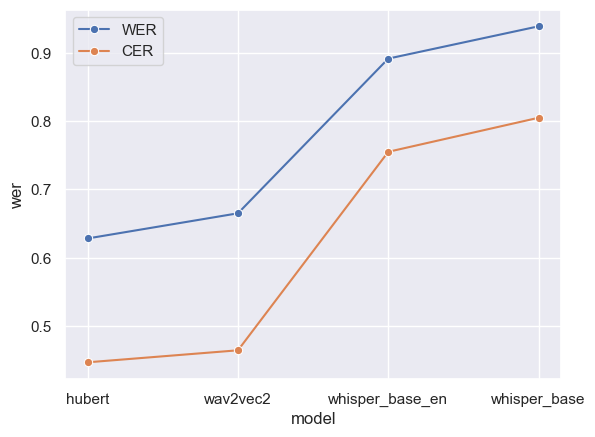

In [78]:
# plot a line plot of the WER for each model with the standard deviation

wer_df = wer_df.sort_values(by=['wer'])
sns.set_theme(style="darkgrid")
sns.lineplot(data=wer_df, x="model", y="wer", marker='o', label='WER')
sns.lineplot(data=wer_df, x="model", y="cer", marker='o', label='CER')
plt.legend()   
plt.savefig('../results/wer_avg_en.png')


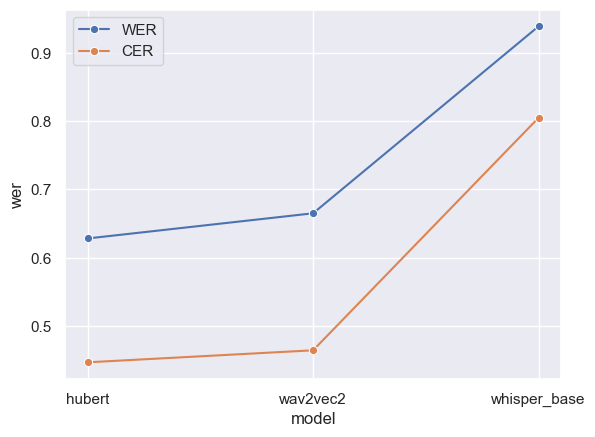

In [71]:
# plot a line plot of the WER for each model with the standard deviation
# exclude whisper_base_en
wer_df = wer_df[wer_df['model'] != 'whisper_base_en']
wer_df = wer_df.sort_values(by=['wer'])
sns.set_theme(style="darkgrid")
sns.lineplot(data=wer_df, x="model", y="wer", marker='o', label='WER')
sns.lineplot(data=wer_df, x="model", y="cer", marker='o', label='CER')
plt.legend()   
plt.savefig('../results/wer_avg.png')



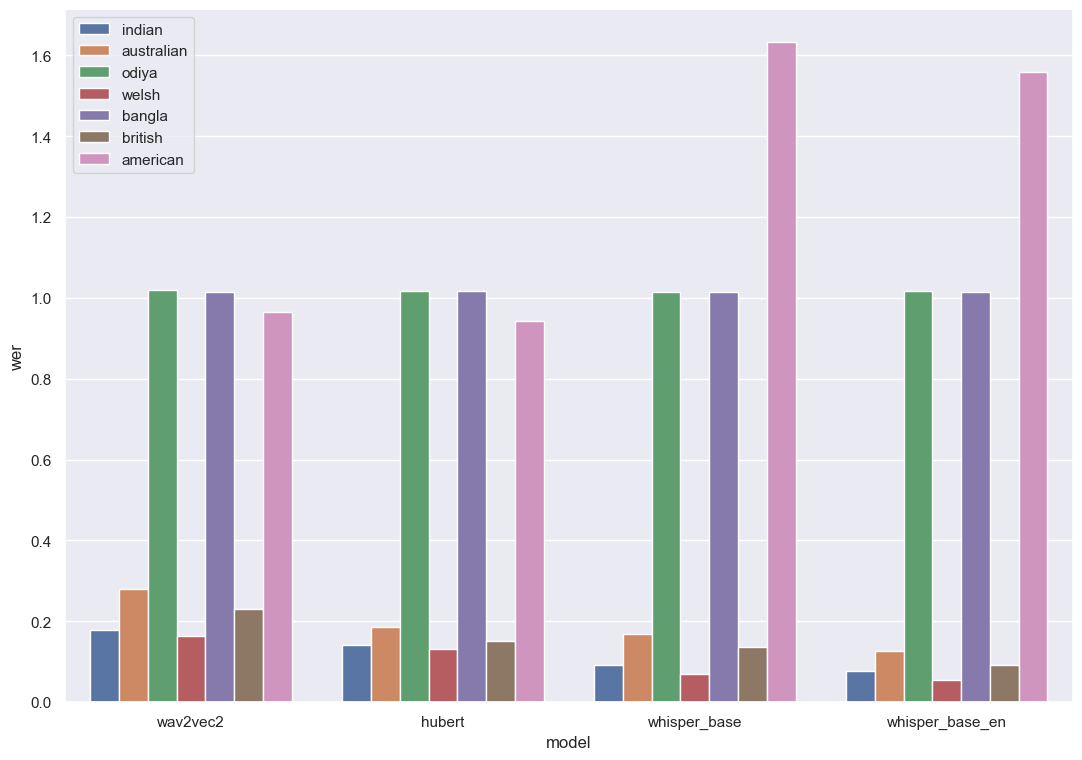

In [89]:
# plot a bar plot of the WER for each model per accent 
# make it bigger
plt.figure(figsize=(13, 9))
sns.set_theme(style="darkgrid")
sns.barplot(data=wer_accent_df, x="model", y="wer", hue="accent")
plt.legend()
plt.savefig('../results/plots/wer_accent_en.png')


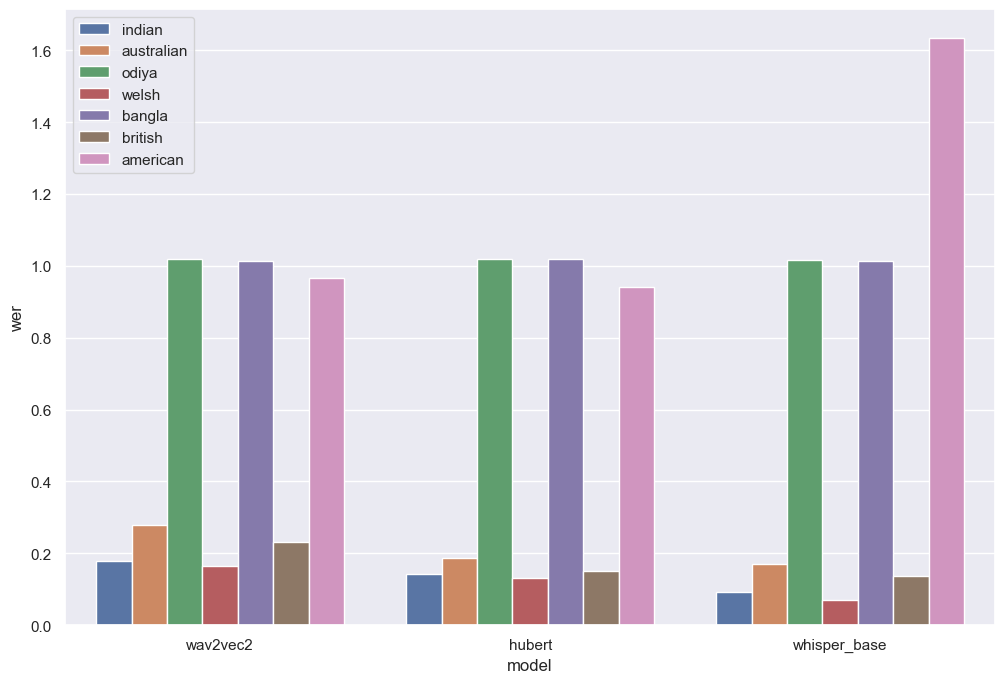

In [81]:
# exclude whisper_base_en
wer_accent_df = wer_accent_df[wer_accent_df['model'] != 'whisper_base_en']
# plot a bar plot of the WER for each model per accent
# make it bigger
plt.figure(figsize=(12, 8))
sns.set_theme(style="darkgrid")
sns.barplot(data=wer_accent_df, x="model", y="wer", hue="accent")
plt.legend()
plt.savefig('../results/plots/wer_accent.png')

## Normalized WER improvement analysis

Looking at the previous section we can see that all models struggle with american, bangladeshi and odiya accents. When it comes to bangladeshi and odiya we notice that the audio samples are of pour quality, which is why the models struggle to transcribe them. On the other hand, the american accent is a bit more tricky. The audio samples are of good quality, but potentially the models were not trained on this particular american accents, which is why they struggle to transcribe them. Or the models were trained on american accents, but the audio samples are of different american accents, which is why the models struggle to transcribe them.

Therefore, in this section we will exclude them from the analysis and see how the models perform on the rest of the accents.

In [112]:
# Create a dataframe with the average WER and CER for each model without american, bangla and odiya accents
wer_avg_norm_df = wer_accent_df[~wer_accent_df['accent'].isin(['bangla', 'american', 'odiya'])].groupby(['model'])['wer'].mean().reset_index()
# add the CER
wer_avg_norm_df['cer'] = wer_accent_df[~wer_accent_df['accent'].isin(['bangla', 'american', 'odiya'])].groupby(['model'])['cer'].mean().reset_index()['cer']
wer_avg_norm_df = wer_avg_norm_df.sort_values(by=['wer'])
wer_avg_norm_df.head()

,model,wer,cer
3,whisper_base_en,0.087095,0.038878
2,whisper_base,0.116656,0.052948
0,hubert,0.152728,0.042149
1,wav2vec2,0.213025,0.067403


In [114]:
# Create a dataframe with the average WER and CER with their std for each model without american, bangla and odiya accents 
wer_avg_norm_df['wer_std'] = wer_accent_df[~wer_accent_df['accent'].isin(['bangla', 'american', 'odiya'])].groupby(['model'])['wer'].std().reset_index()['wer']
wer_avg_norm_df['cer_std'] = wer_accent_df[~wer_accent_df['accent'].isin(['bangla', 'american', 'odiya'])].groupby(['model'])['cer'].std().reset_index()['cer']
wer_avg_norm_df.head()

,model,wer,cer,wer_std,cer_std
3,whisper_base_en,0.087095,0.038878,0.030538,0.015822
2,whisper_base,0.116656,0.052948,0.044307,0.023650
0,hubert,0.152728,0.042149,0.023565,0.011476
1,wav2vec2,0.213025,0.067403,0.052773,0.024953


In [105]:
# What is the percentage of improvement of whisper_base_en over the whisper_base? Use the average WER of the whisper_base_en and whisper_base models.

print(f"WER whisper_base: {wer_avg_norm_df[wer_avg_norm_df['model'] == 'whisper_base']['wer'].values[0]}")
print(f"WER whisper_base_en: {wer_avg_norm_df[wer_avg_norm_df['model'] == 'whisper_base_en']['wer'].values[0]}")
print(f"WER improvement whisper_base_en over whisper_base: {round(100 - (wer_avg_norm_df[wer_avg_norm_df['model'] == 'whisper_base_en']['wer'].values[0] / wer_avg_norm_df[wer_avg_norm_df['model'] == 'whisper_base']['wer'].values[0]) * 100, 2)}%")

WER whisper_base: 0.1166564183993198
WER whisper_base_en: 0.08709545499122917
WER improvement whisper_base_en over whisper_base: 25.34%


This implies that 'whisper_base_en' has a 25.34% lower Word Error Rate (WER) compared to 'whisper_base'.

In [107]:
# What is the percentage of improvement of whisper_base_en over the hubert? Use the average WER of the whisper_base_en and hubert models.\

print(f"WER hubert: {wer_avg_norm_df[wer_avg_norm_df['model'] == 'hubert']['wer'].values[0]}")
print(f"WER whisper_base_en: {wer_avg_norm_df[wer_avg_norm_df['model'] == 'whisper_base_en']['wer'].values[0]}")
print(f"WER improvement whisper_base_en over hubert: {round(100 - (wer_avg_norm_df[wer_avg_norm_df['model'] == 'whisper_base_en']['wer'].values[0] / wer_avg_norm_df[wer_avg_norm_df['model'] == 'hubert']['wer'].values[0]) * 100, 2)}%")

WER hubert: 0.1527276584587734
WER whisper_base_en: 0.08709545499122917
WER improvement whisper_base_en over hubert: 42.97%


This implies that 'whisper_base_en' has a 42.97% lower Word Error Rate (WER) compared to 'hubert'.

In [108]:
# What is the percentage of improvement of whisper_base_en over the wav2vec2? Use the average WER of the whisper_base_en and wav2vec2 models.

print(f"WER wav2vec2: {wer_avg_norm_df[wer_avg_norm_df['model'] == 'wav2vec2']['wer'].values[0]}")
print(f"WER whisper_base_en: {wer_avg_norm_df[wer_avg_norm_df['model'] == 'whisper_base_en']['wer'].values[0]}")
print(f"WER improvement whisper_base_en over wav2vec2: {round(100 - (wer_avg_norm_df[wer_avg_norm_df['model'] == 'whisper_base_en']['wer'].values[0] / wer_avg_norm_df[wer_avg_norm_df['model'] == 'wav2vec2']['wer'].values[0]) * 100, 2)}%")

WER wav2vec2: 0.21302544469353238
WER whisper_base_en: 0.08709545499122917
WER improvement whisper_base_en over wav2vec2: 59.11%


This implies that 'whisper_base_en' has a 59.11% lower Word Error Rate (WER) compared to 'wav2vec'.

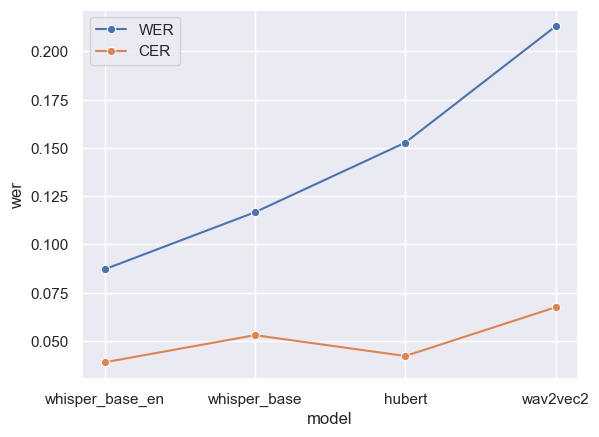

In [115]:
# plot a line plot of the WER for each model with the standard deviation
# order the models by WER

wer_avg_norm_df = wer_avg_norm_df.sort_values(by=['wer'])
sns.set_theme(style="darkgrid")
sns.lineplot(data=wer_avg_norm_df, x="model", y="wer", marker='o', label='WER')
sns.lineplot(data=wer_avg_norm_df, x="model", y="cer", marker='o', label='CER')
plt.legend()   
plt.savefig('../results/wer_avg_en_normalized.png')


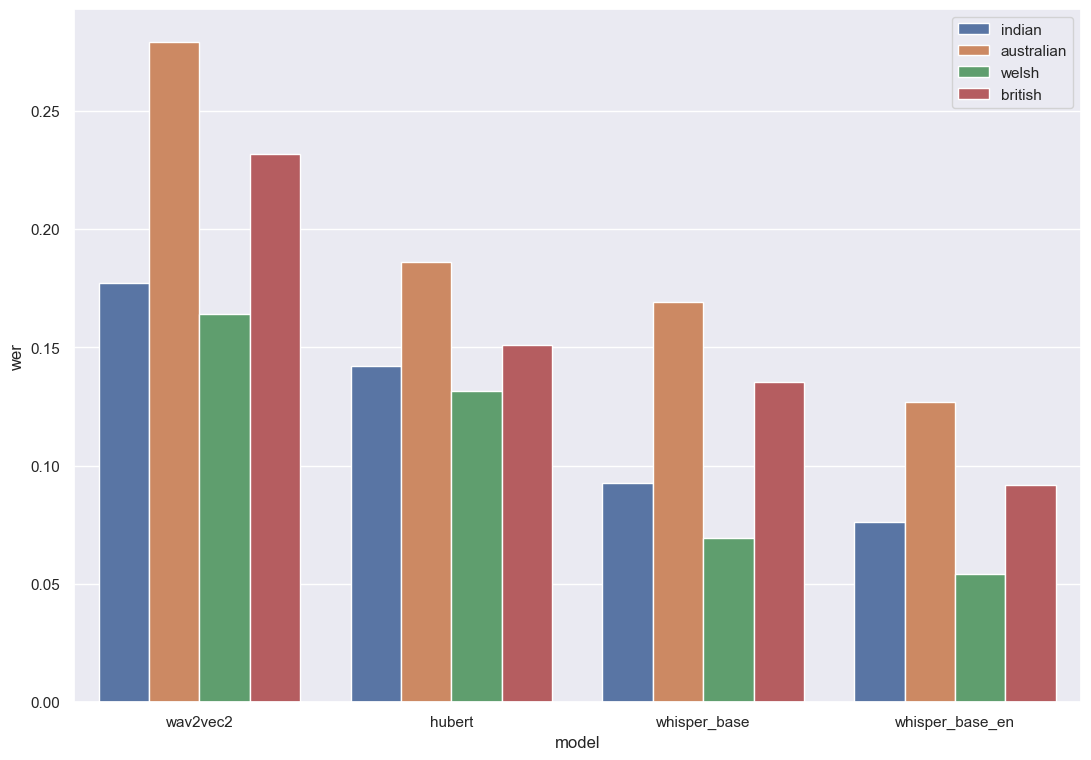

In [90]:
# plot a bar plot of the WER for each model per accent 
# make it bigger
plt.figure(figsize=(13, 9))
sns.set_theme(style="darkgrid")
# Exclude bangla, american and odiya
sns.barplot(data=wer_accent_df[~wer_accent_df['accent'].isin(['bangla', 'american', 'odiya'])], x="model", y="wer", hue="accent")
plt.legend()
plt.savefig('../results/plots/wer_accent_en_normalized.png')


When excluding these three accents, our observations showcase that the English-only variant of Whisper (whisper base en), outperforms all models regarding both Word Error Rate (WER) and Character Error Rate (CER).

Specifically, the English variant of the Whisper (*whisper_base_en*) model delivers a remarkable 25% im- provement in WER score on the AccentsDB compared to the standard Whisper Base model. More impressively, the specialized model outperformed HubERT and Wav2Vec 2.0 by 43% and 59%, respectively. This accomplishment is especially notable considering the Whisper models’ size, which is measured in terms of their parameters. In the field of machine learning, parameters define a model’s behaviour, influencing its ability to learn from data and hence, its eventual performance.

Comprising roughly 74M parameters, both Whisper variants - whisper base en and whisper base - are considerably smaller than their counterparts. For instance, HuBERT is four times larger with 317M parameters, while Wav2Vec 2.0 has a similar size with 95M parameters.